# DE Portoflio 1: Foundations of Logistic Regression

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to predict the probability to identify the terrorist group responsible for an event given that the attack happened in Europe and North America. This will be assesed based on the output being 1 or Yes (we have a name identifying the terrorist group) and 0 or No if the name is unknown.

Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

### Load and Prepare Data

In [2]:
#Read dataset
df=pd.read_csv('Data_All.csv')
display(df)

C:\Users\maria\AppData\Local\Temp\ipykernel_15244\2447770691.py:2: DtypeWarning: Columns (4,31,33,37,54,61,62,63,76,79,90,92,94,96,114,115,121,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data_All.csv')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Electricity
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Other Personnel
214663,202106300030,2021,6,30,NaN,1,2021-07-08,147,Nigeria,11,...,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN,Religious Figure
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN,NaN


#### Features selected
1. attacktype1_txt: categorical value defining the attack type of the event
    - For this model we focus only on hostake taking
2. targtype1_txt: (categorical value) explaining the types of targets attacked by the terrorist organisation
    - For this model we focus on citizens, civillians and private property
3. gname: The name of the terrorist organisation responsible for attack
4. property: If a property was attacked during the terrorist incident  (1 = Yes; 0 = No)
5. doubtterr: Binary value, explains whether there were doubts about the attack being organized by a terrorist group (1= Doubts, 0= No doubts)
6. region_txt: categorical value for regions where attacks took place
    - For this model we focus on Europe and North America


In [3]:
#Select relevant features
features=['region_txt',  'doubtterr', 'attacktype1_txt', 'targtype1_txt', 'gname', 'property']
df=df[features]

#Filter dataframe so it includes only values from Europe and North America
df = df[df['region_txt'].isin(['Western Europe', 'Eastern Europe', 'North America'])]

#Replace values called unknown or other with Nan and drop them
values_to_replace = ['Unknown', 'Other']
#An exception is made for terrorist group name since we need unknown values for our model
df.loc[:, df.columns != 'gname'] = df.loc[:, df.columns != 'gname'].replace(values_to_replace, pd.NA)
df=df.dropna()
display(df)

,region_txt,doubtterr,attacktype1_txt,targtype1_txt,gname,property
1,North America,0,Hostage Taking (Kidnapping),Government (Diplomatic),23rd of September Communist League,0
3,Western Europe,0,Bombing/Explosion,Government (Diplomatic),Unknown,1
5,North America,0,Armed Assault,Police,Black Nationalists,1
7,North America,1,Bombing/Explosion,Utilities,Unknown,1
8,North America,0,Facility/Infrastructure Attack,Military,New Year's Gang,1
...,...,...,...,...,...,...
214599,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,1
214635,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,1
214637,Western Europe,0,Facility/Infrastructure Attack,Government (General),Unknown,1
214652,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,1


In [4]:
#Define Y value
#If a terrorist group is known, Y is 1
Y= df['gname'].apply(lambda x:0 if x =='Unknown' else 1)

#Encode attack types
attacks=['Hostage Taking (Barricade Incident)', 'Hostake Taking (Kidnapping)']
attack_matrix=df['attacktype1_txt'].apply(lambda x:1 if x in attacks else 0)

#Encode target types
target=['Private Citizens & Property', 'Journalists & Media', 'Tourists']
target_matrix=df['targtype1_txt'].apply(lambda x:1 if x in target else 0)

#Encode regions
region_type=pd.get_dummies(df['region_txt'], drop_first=True)
region_matrix = region_type.astype(int)

#Ensure numerical features are integers
doubt_attack=df['doubtterr'].astype(int)
property=df['property'].astype(int)

#Create design matrix
X = pd.concat([doubt_attack, target_matrix, attack_matrix, region_matrix, property], axis=1)



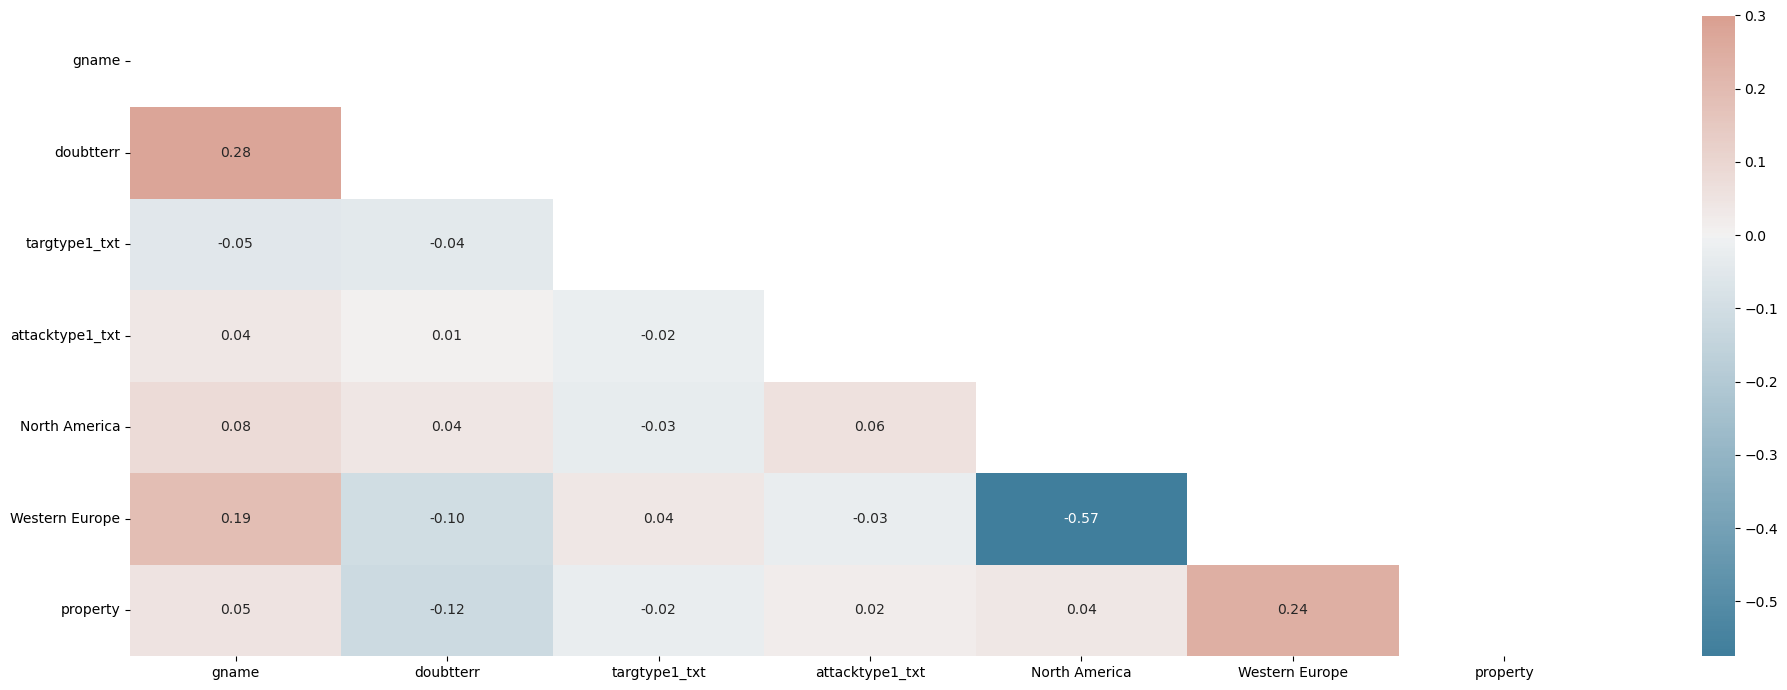

In [5]:
#Explore correlation and check for multicollinearity
import seaborn as sns

#Add Y to X values as a way of examining correlation between features and outcome 
X['gname'] = Y

#Set Y as the first column
YX = X[['gname'] + [c for c in X.columns if c != 'gname']]

#Calculate correlations
corr = YX.corr()

#Plot matrix
plt.figure(figsize=(20, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 10})

plt.tight_layout()
plt.show()

### Fit Logistic Regression Model

In [6]:
import statsmodels.api as sm 
import pandas as pd

#Define dependent and independent values
Y=Y
X = pd.concat([doubt_attack, target_matrix, attack_matrix, region_matrix, property], axis=1)

#Add constant and fit the model
X_with_constant=sm.add_constant(X)
model=sm.Logit(Y, X_with_constant).fit()

#Print summary of model
summary = model.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.562755
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  gname   No. Observations:                25695
Model:                          Logit   Df Residuals:                    25688
Method:                           MLE   Df Model:                            6
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.1461
Time:                        13:42:12   Log-Likelihood:                -14460.
converged:                       True   LL-Null:                       -16933.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6561      0.032    -20.209      0.000      -0.720      -0.592
doubtterr     

### Evaluate Coefficients

In [7]:
#Get coefficients and covariance matrix
b_mean = model.params
b_cov = model.cov_params()

#Simulate coefficients
sim_beta= np.random.multivariate_normal(b_mean, b_cov, 1000)


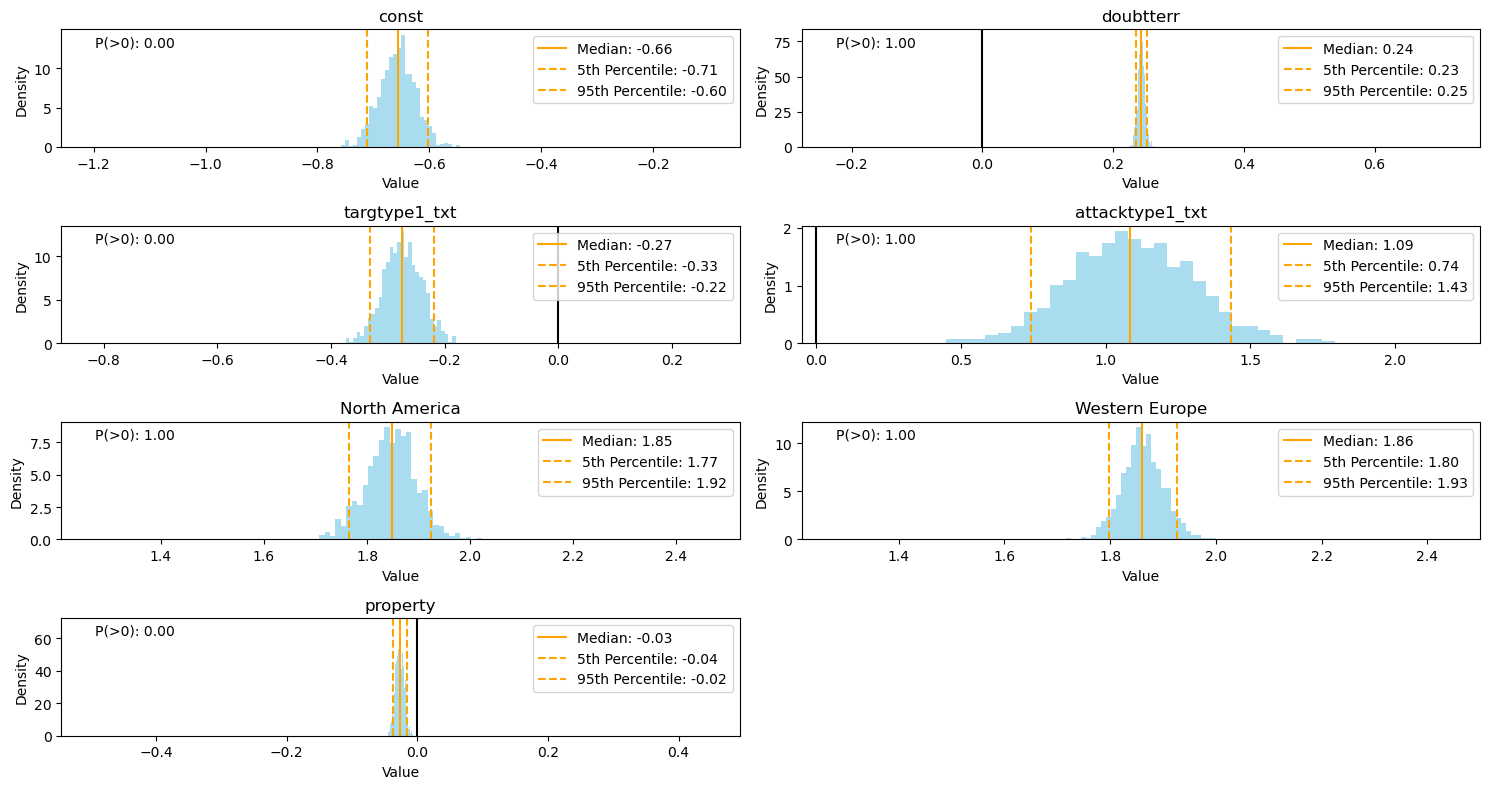

In [8]:
#Calculate the number of coefficients in the model
num_c = X_with_constant.shape[1]

#Calculate stats for each coefficient used in the model
medians = np.median(sim_beta, axis=0)
low = np.percentile(sim_beta, 5, axis=0)
up= np.percentile(sim_beta, 95, axis=0)
positive = np.mean(sim_beta > 0, axis=0)

#Plot histograms per coefficient
num_rows = (num_c + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(num_c):
    ax = axs[i]
    ax.hist(sim_beta[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0 - probabiliyt of coefficient to be above 0
    ax.axvline(0, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(low[i], color='orange', linestyle='--', label=f'5th Percentile: {low[i]:.2f}')
    ax.axvline(up[i], color='orange', linestyle='--', label=f'95th Percentile: {up[i]:.2f}')
    
    # Add text annotation for probability above 0
    ax.text(0.05, 0.95, f'P(>0): {positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{X_with_constant.columns[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 0
    ax.set_xlim(left=min(sim_beta[:, i]) - 0.5, right=max(sim_beta[:, i]) + 0.5)
    
#Hide empty plots
if num_c % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### Generate New Predictions and Probabilities

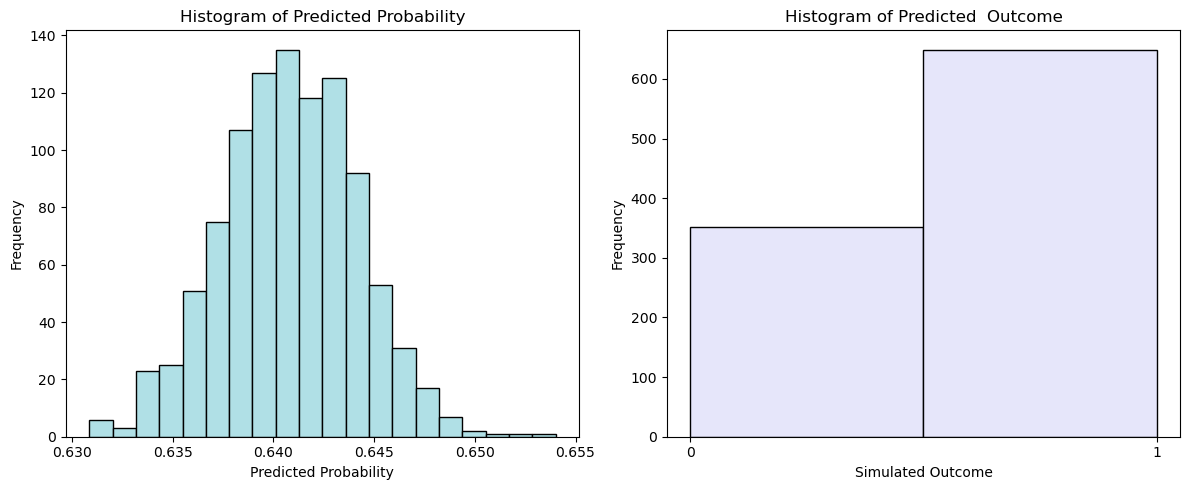

In [9]:
#Get average sample for each indepedent feature
avg_X = X_with_constant.mean(axis=0)

#Get new prediction probabilities
probs = logistic_sigmoid(np.dot(sim_beta, avg_X))

#Simulated new outcomes based on the new predicition probabilities
outcomes = np.random.binomial(1, probs)

#Plot predicted probabilities and outcomes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for probability
axes[0].hist(probs, bins=20, color='powderblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for outcomes
axes[1].hist(outcomes, bins=2, color='lavender', edgecolor='black')
axes[1].set_title('Histogram of Predicted  Outcome')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()

#### Interpretation
The plots show the predicted probabilities and classes as a result of a logistic regression model with the task of predicting ability to identify (or know) the name of terrorist groups responsible for an attack. The first histogram shows that the predicted probabilities of knowing the name of perpetrators revolve around 63-64% while the second histogram shows that the most likely outcome is to know the name of the group.